In [21]:
import pandas as pd
import numpy as np
import datetime
#from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from skfeature.function.similarity_based import fisher_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
import pyfolio as pf
from finrl.plot import backtest_plot
from sklearn.svm import SVC

In [22]:
BIO = pd.read_csv("phase3_data/bio.csv")
BIO = BIO.loc[:, 'Report Date': 's_diff']
BIO['Report Date'] = pd.to_datetime(BIO['Report Date'])
all_date_column = BIO['Report Date']

In [23]:
BIO['Return'] = BIO['Stock price'].pct_change()
BIO['Stock price'] = BIO['Stock price'].shift(-1)
BIO['Y_boolean'] = BIO['Y_boolean'].shift(-1)
BIO['Return'] = BIO['Return'].shift(-1)
BIO = BIO.dropna()


In [24]:
BIO

,Report Date,Stock price,Y_boolean,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Debt Ratio,Dividends / FCF,Dummy_Dividends,...,Return on Equity,Return on Research Capital,Share Buyback / FCF,tweet_polarity,tweet_subjectivity,RSI_ratio,MACD,p_diff,s_diff,Return
0,2020-03-02,370.000000,0.0,0.039077,1.000000,0,0.066882,1.0,0,0,...,0.569072,0.234577,0.039077,0.416435,0.000000,0.282601,0.369822,0.369401,0.680329,0.002846
1,2020-03-03,384.929993,1.0,0.039077,1.000000,0,0.066882,1.0,0,0,...,0.569072,0.234577,0.039077,0.569010,0.178823,0.282601,0.342703,0.234587,0.680329,0.040351
2,2020-03-04,386.679993,1.0,0.039077,1.000000,0,0.066882,1.0,0,0,...,0.569072,0.234577,0.039077,0.417248,0.673164,0.282601,0.290270,0.169418,1.000000,0.004546
3,2020-03-05,374.559998,-1.0,0.039077,1.000000,0,0.066882,1.0,0,0,...,0.569072,0.234577,0.039077,0.010260,0.122699,0.282601,0.260227,0.080192,0.000000,-0.031344
4,2020-03-06,366.819997,-1.0,0.039077,1.000000,0,0.066882,1.0,0,0,...,0.569072,0.234577,0.039077,0.118097,0.220400,0.282601,0.281299,0.167766,0.573664,-0.020664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,2022-04-19,562.010010,1.0,0.002722,0.093347,0,0.388057,0.0,0,0,...,0.000000,0.202123,0.002722,0.517732,0.727515,0.225021,0.539724,0.182817,0.709518,0.009974
779,2022-04-20,545.239990,-1.0,0.002722,0.093347,0,0.388057,0.0,0,0,...,0.000000,0.202123,0.002722,0.482144,0.560711,0.446084,0.511206,0.186006,0.326909,-0.029839
780,2022-04-21,534.289978,-1.0,0.002722,0.093347,0,0.388057,0.0,0,0,...,0.000000,0.202123,0.002722,0.688498,0.459994,0.305393,0.535049,0.234409,0.374780,-0.020083
781,2022-04-22,532.843323,0.0,0.002722,0.093347,0,0.388057,0.0,0,0,...,0.000000,0.202123,0.002722,0.565511,0.683622,0.325206,0.573000,0.178642,0.672782,-0.002708


In [5]:
# function to select data given date window
def window(start, end, df, all_date_column):
    '''
    Given a start and end date, return df with data only
    from that period
    
    Inputs:
        start/end: start and end dates
            ex: start = '2022-01-23' ('YYYY-MM-DD')
        df: pd dataframe
        date: pd series with dates of all possible dates in data
    
    Returns: pd dataframe
    '''

    date_column = all_date_column[all_date_column.between(start, end, inclusive='both')]
    df = pd.concat([date_column, df], axis = 1, join="inner")
    df = df.iloc[:, 1:]

    return df

In [6]:
def feature_selection_FS(training_dataset, testing_dataset, bar):
    """
    find the important feature using Fishers' score
    """

    X = training_dataset.iloc[:, 3:-1]
    Y_price = training_dataset['Stock price']
    Y_dummy = training_dataset['Y_boolean']
    date_train = training_dataset['Report Date']
    date_test = testing_dataset['Report Date']

    ranks = fisher_score.fisher_score(X.to_numpy(), Y_dummy)
    feat_importances = pd.Series(ranks, training_dataset.columns[3:-1])
#     feat_importances.plot(kind='barh', color ="teal")
#     plt.show()
    
    feat_selected = feat_importances.to_frame('importance')
    # select importance > than bar
    feat_selected = feat_selected[feat_selected['importance'] > bar]
    select_feature_lst = ['Report Date', 'Stock price', 'Y_boolean'] + list(feat_selected.index)
    
    return training_dataset[select_feature_lst], testing_dataset[select_feature_lst]
    
    
    

In [7]:
def feature_selection_IG(training_dataset, testing_dataset, bar):
    """
    find the important feature using IG method
    """

    X = training_dataset.iloc[:, 3:-1]
    Y_price = training_dataset['Stock price']
    Y_dummy = training_dataset['Y_boolean']
    date_train = training_dataset['Report Date']
    date_test = testing_dataset['Report Date']
    importances = mutual_info_classif(X, Y_dummy, random_state=1241)
    feat_importances = pd.Series(importances, training_dataset.columns[3:-1])
#     feat_importances.plot(kind='barh', color ="teal")
#     plt.show()

    feat_selected = feat_importances.to_frame('importance')
    # select importance > than bar
    feat_selected = feat_selected[feat_selected['importance'] > bar]
    select_feature_lst = ['Report Date', 'Stock price', 'Y_boolean'] + list(feat_selected.index)
    
    return training_dataset[select_feature_lst], testing_dataset[select_feature_lst]
    

In [8]:
def test_feature_select(training_dataset, validate_dataset):
    """
    check the performance of the current selected: use only training dataset accuracy 
    """
    # run baseline logit
    logit = LogisticRegression(solver = 'lbfgs', random_state=1241)
    X = training_dataset.iloc[:, 3:-1]
    Y_dummy = training_dataset['Y_boolean']
    logit.fit(X, Y_dummy)
    Y_dummy_validate = validate_dataset['Y_boolean']
    X_validate = validate_dataset.iloc[:, 3:-1]
    Y_pred = logit.predict(X_validate)
    # pred = lr.predict(testing_dataset)
#     score = logit.score(testing_dataset, Y_true)
    
    score = accuracy_score(Y_dummy_validate, Y_pred)
    return score

In [9]:
# collect all date
date_starts = []
date = datetime.datetime(2020, 3, 2)
date_starts.append(date)

for idx in range(660):#range(722):
    date += datetime.timedelta(days=1)
    date_starts.append(date)
    


In [12]:
# currently using BIO as example
# loop for feature selection and modeling
features_selected = []

for train_date_start in date_starts:
    print(train_date_start)
    train_date_end = train_date_start + datetime.timedelta(days=90)
    validate_date_start = train_date_end + datetime.timedelta(days=1)
    validate_date_end = validate_date_start + datetime.timedelta(days=30)
    test_date_start = validate_date_end + datetime.timedelta(days=1)
    test_date_end = test_date_start

    train_data = window(train_date_start, train_date_end, BIO, all_date_column)
    validate_data = window(validate_date_start, validate_date_end, BIO, all_date_column)
    test_data = window(test_date_start, test_date_end, BIO, all_date_column)

    bars_FS = range(0, 11)
    bars_IG = np.arange(0, 0.03, 0.005)#np.arange(0, 0.1005, 0.005)
 
    best_accuracy = 0
    best_bar = []
    best_features = []
    
    for bar_FS in bars_FS:
        for bar_IG in bars_IG:
            
            try:
                train_BIO_selected, validate_BIO_selected = feature_selection_FS(train_data, validate_data, bar_FS)
                train_BIO_selected, validate_BIO_selected = feature_selection_IG(train_BIO_selected, validate_BIO_selected, bar_IG)
                score = test_feature_select(train_BIO_selected, validate_BIO_selected)
                if score > best_accuracy:
                    best_accuracy = score
                    best_bar = [bar_FS, bar_IG]
                    best_features = train_BIO_selected.iloc[:,3:].columns
            except:
                continue
    features_selected.append(best_features)

2020-03-02 00:00:00
2020-03-03 00:00:00
2020-03-04 00:00:00
2020-03-05 00:00:00
2020-03-06 00:00:00
2020-03-07 00:00:00
2020-03-08 00:00:00
2020-03-09 00:00:00
2020-03-10 00:00:00
2020-03-11 00:00:00
2020-03-12 00:00:00
2020-03-13 00:00:00
2020-03-14 00:00:00
2020-03-15 00:00:00
2020-03-16 00:00:00
2020-03-17 00:00:00
2020-03-18 00:00:00
2020-03-19 00:00:00
2020-03-20 00:00:00
2020-03-21 00:00:00
2020-03-22 00:00:00
2020-03-23 00:00:00
2020-03-24 00:00:00
2020-03-25 00:00:00
2020-03-26 00:00:00
2020-03-27 00:00:00
2020-03-28 00:00:00
2020-03-29 00:00:00
2020-03-30 00:00:00
2020-03-31 00:00:00
2020-04-01 00:00:00
2020-04-02 00:00:00
2020-04-03 00:00:00
2020-04-04 00:00:00
2020-04-05 00:00:00
2020-04-06 00:00:00
2020-04-07 00:00:00
2020-04-08 00:00:00
2020-04-09 00:00:00
2020-04-10 00:00:00
2020-04-11 00:00:00
2020-04-12 00:00:00
2020-04-13 00:00:00
2020-04-14 00:00:00
2020-04-15 00:00:00
2020-04-16 00:00:00
2020-04-17 00:00:00
2020-04-18 00:00:00
2020-04-19 00:00:00
2020-04-20 00:00:00


2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-17 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00
2021-05-21 00:00:00
2021-05-22 00:00:00
2021-05-23 00:00:00
2021-05-24 00:00:00
2021-05-25 00:00:00
2021-05-26 00:00:00
2021-05-27 00:00:00
2021-05-28 00:00:00
2021-05-29 00:00:00
2021-05-30 00:00:00
2021-05-31 00:00:00
2021-06-01 00:00:00
2021-06-02 00:00:00
2021-06-03 00:00:00
2021-06-04 00:00:00


In [13]:
list(features_selected[0])

['Current Ratio',
 'Debt Ratio',
 'Dividends / FCF',
 'Dummy_Dividends',
 'Gross Profit Margin',
 'Quick Ratio',
 'R&D / Gross Profit',
 'R&D / Revenue',
 'Return on Assets',
 'Return on Equity',
 'Share Buyback / FCF',
 'tweet_polarity',
 'tweet_subjectivity',
 'RSI_ratio',
 'MACD']

In [14]:
features_selected[0]

Index(['Current Ratio', 'Debt Ratio', 'Dividends / FCF', 'Dummy_Dividends',
       'Gross Profit Margin', 'Quick Ratio', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Assets', 'Return on Equity',
       'Share Buyback / FCF', 'tweet_polarity', 'tweet_subjectivity',
       'RSI_ratio', 'MACD'],
      dtype='object')

In [28]:
import pickle

In [29]:
with open('BIO features', 'wb') as f:
    pickle.dump(features_selected, f)

In [30]:
with open('BIO features', 'rb') as f:
    features_selected = pickle.load(f)

In [31]:
models = {'random forest': RandomForestClassifier(random_state=0,
                            n_jobs=-1,
                            n_estimators=10,
                            class_weight='balanced'),
          'logistic regression': LogisticRegression(max_iter=1000,
                                                    penalty='l2',
                                                    tol=0.001,
                                                    solver='newton-cg'),
          'SVC': SVC(kernel='poly'),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'gradient boosting':GradientBoostingClassifier(max_depth= 10, random_state=0, n_estimators=10)
         }

In [32]:
results = {}
for model_name, model in models.items():
    if model_name not in results:
        dates = []
        predictions = []
        truth = []
        returns = []
        for train_date_start, features in zip(date_starts, features_selected):
            train_date_end = train_date_start + datetime.timedelta(days=90)
            validate_date_start = train_date_end + datetime.timedelta(days=1)
            validate_date_end = validate_date_start + datetime.timedelta(days=30)
            test_date_start = validate_date_end + datetime.timedelta(days=1)
            test_date_end = test_date_start

            train_data = window(train_date_start, train_date_end, BIO, all_date_column)
            validate_data = window(validate_date_start, validate_date_end, BIO, all_date_column)
            test_data = window(test_date_start, test_date_end, BIO, all_date_column)

            train = pd.concat([train_data, validate_data])

            model.fit(train[features], train['Y_boolean'])
            predictions.append(model.predict(test_data[features])[0])
            dates.append(test_data['Report Date'].values[0])
            truth.append(test_data['Y_boolean'].values[0])
            returns.append(test_data['Return'].values[0])
        results[model_name] = pd.DataFrame({'date':dates, 
                                            'prediction': predictions,
                                            'truth': truth,
                                            'returns': returns})
        results[model_name]['portfolio returns'] = results[model_name]['returns'] * results[model_name]['prediction']
        results[model_name]['portfolio cumulative returns'] = np.cumprod(1 + results[model_name]['portfolio returns'])


In [33]:
for model_name in results.keys():
    acc = sum(results[model_name]['prediction'] == results[model_name]['truth']) / len(results[model_name])
    print(f'{model_name} score:{round(acc,3)}')

random forest score:0.495
logistic regression score:0.396
SVC score:0.421
KNN score:0.41
gradient boosting score:0.452


In [34]:
def backtest(df):
    df_account_value = df[['date', 'portfolio cumulative returns']]
    df_account_value.columns = ['date', 'account_value']
    backtest_plot(df_account_value, 
              baseline_ticker='SPY',
              baseline_start = df_account_value.date.iloc[0],
              baseline_end = df_account_value.date.iloc[-1])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,31.592%
Cumulative returns,105.466%
Annual volatility,21.483%
Sharpe ratio,1.39
Calmar ratio,1.79
Stability,0.67
Max drawdown,-17.662%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.66,2021-01-25,2021-06-01,2021-12-08,228
1,13.75,2020-07-29,2020-09-05,2020-10-28,66
2,11.38,2022-02-22,2022-02-24,2022-03-07,10
3,9.25,2021-12-09,2022-01-03,2022-01-13,26
4,8.86,2020-11-10,2020-11-24,2020-12-17,28


Stress Events,mean,min,max
New Normal,0.12%,-7.16%,7.36%


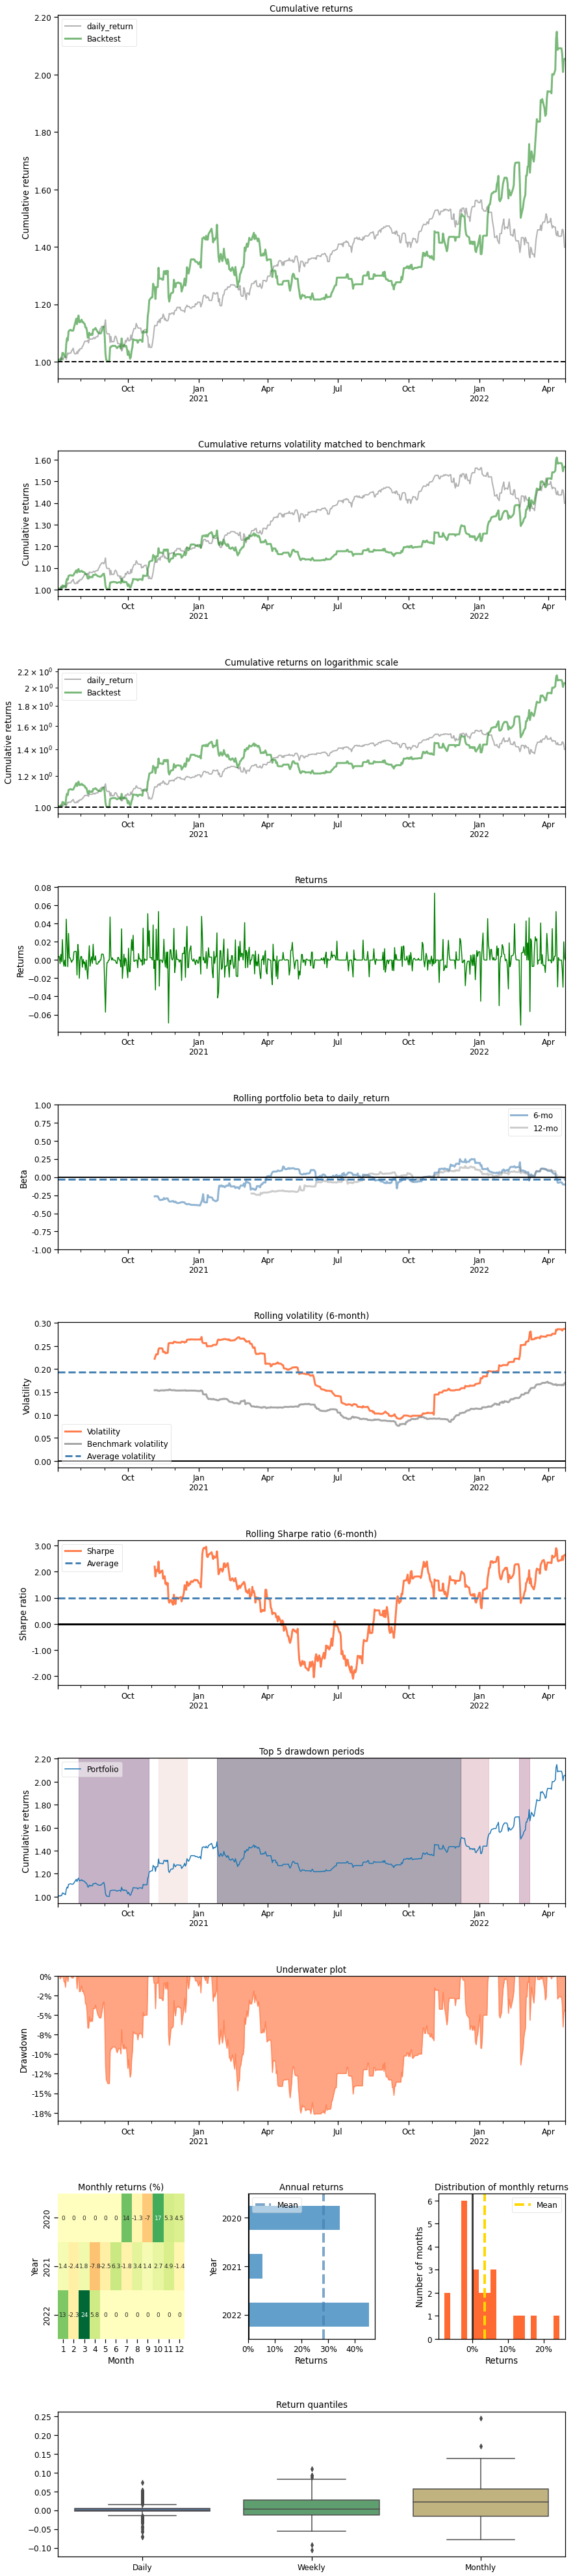

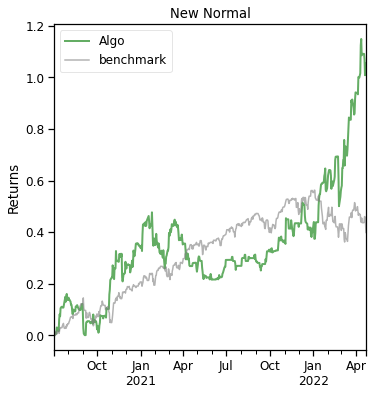

In [35]:
backtest(results['gradient boosting'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,52.916%
Cumulative returns,204.666%
Annual volatility,20.756%
Sharpe ratio,2.15
Calmar ratio,4.24
Stability,0.86
Max drawdown,-12.485%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.48,2021-01-25,2021-02-28,2021-07-01,114
1,12.09,2022-02-22,2022-02-25,2022-03-07,10
2,11.66,2020-07-06,2020-09-04,2020-10-29,84
3,6.27,2021-01-03,2021-01-05,2021-01-25,16
4,5.94,2022-03-10,2022-03-15,2022-03-22,9


Stress Events,mean,min,max
New Normal,0.18%,-7.16%,7.36%


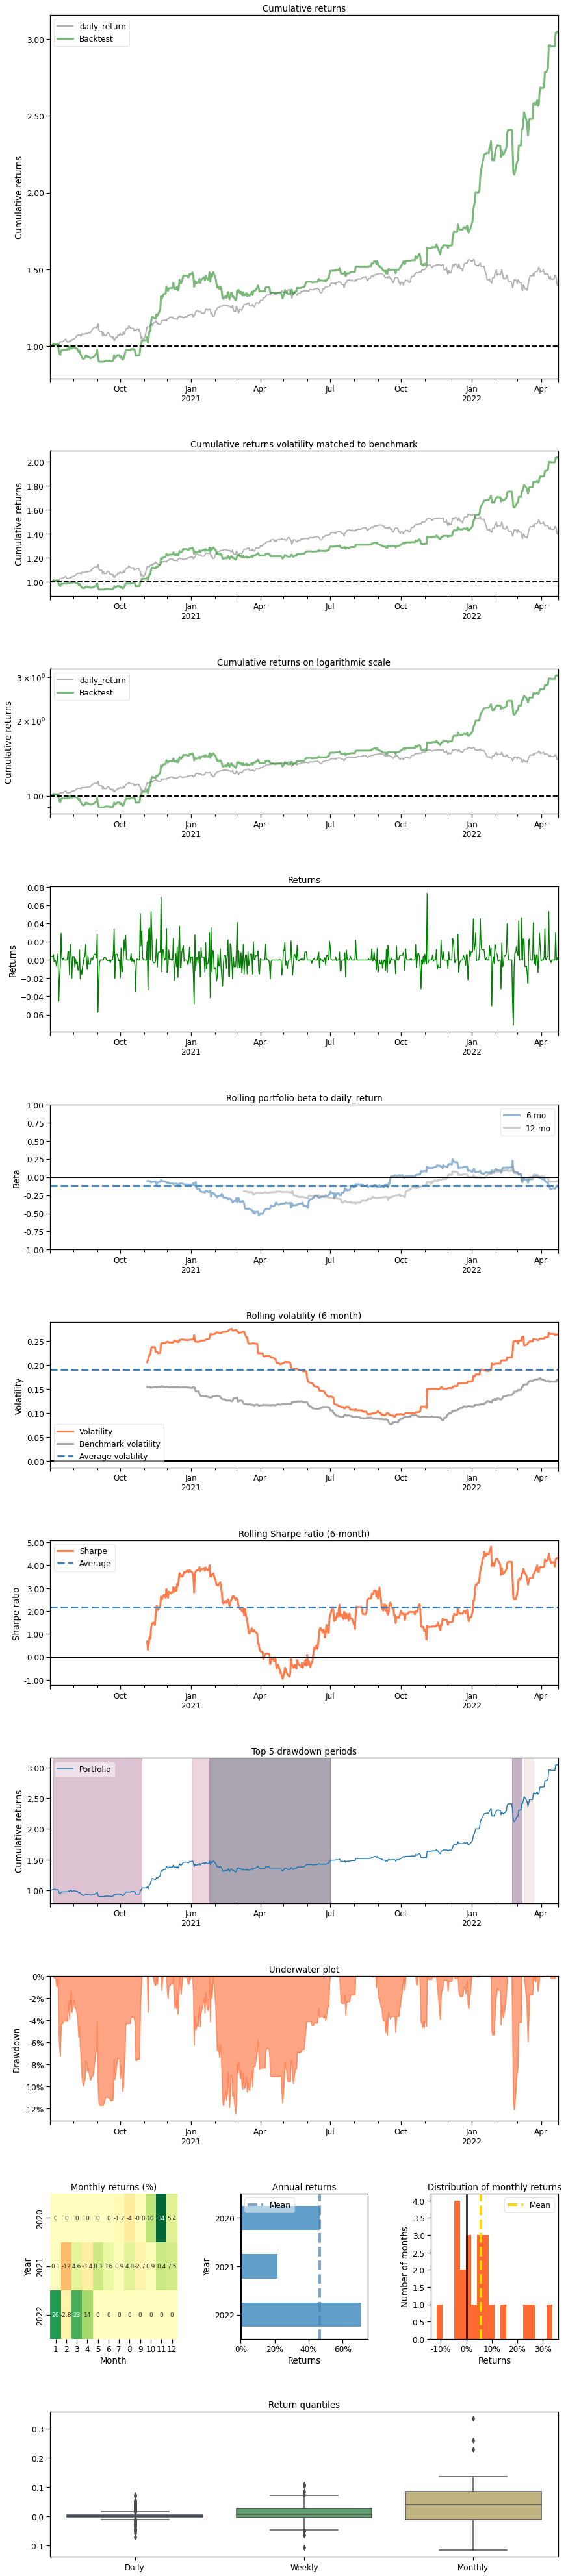

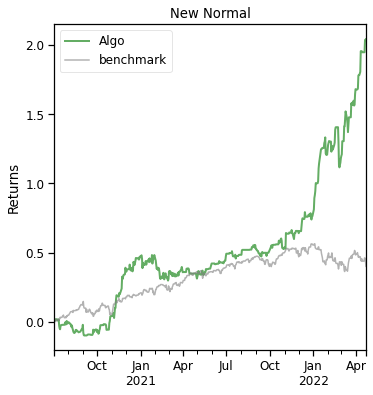

In [36]:
backtest(results['random forest'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,10.159%
Cumulative returns,28.889%
Annual volatility,21.923%
Sharpe ratio,0.55
Calmar ratio,0.48
Stability,0.53
Max drawdown,-21.376%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,21.38,2020-11-05,2021-02-19,2022-01-15,312
1,18.80,2022-03-07,2022-04-22,NaT,NaN
2,12.52,2022-01-26,2022-02-24,2022-03-06,28
3,10.60,2020-07-29,2020-09-07,2020-10-06,50
4,5.10,2020-10-26,2020-10-27,2020-11-01,5


Stress Events,mean,min,max
New Normal,0.05%,-7.16%,7.36%


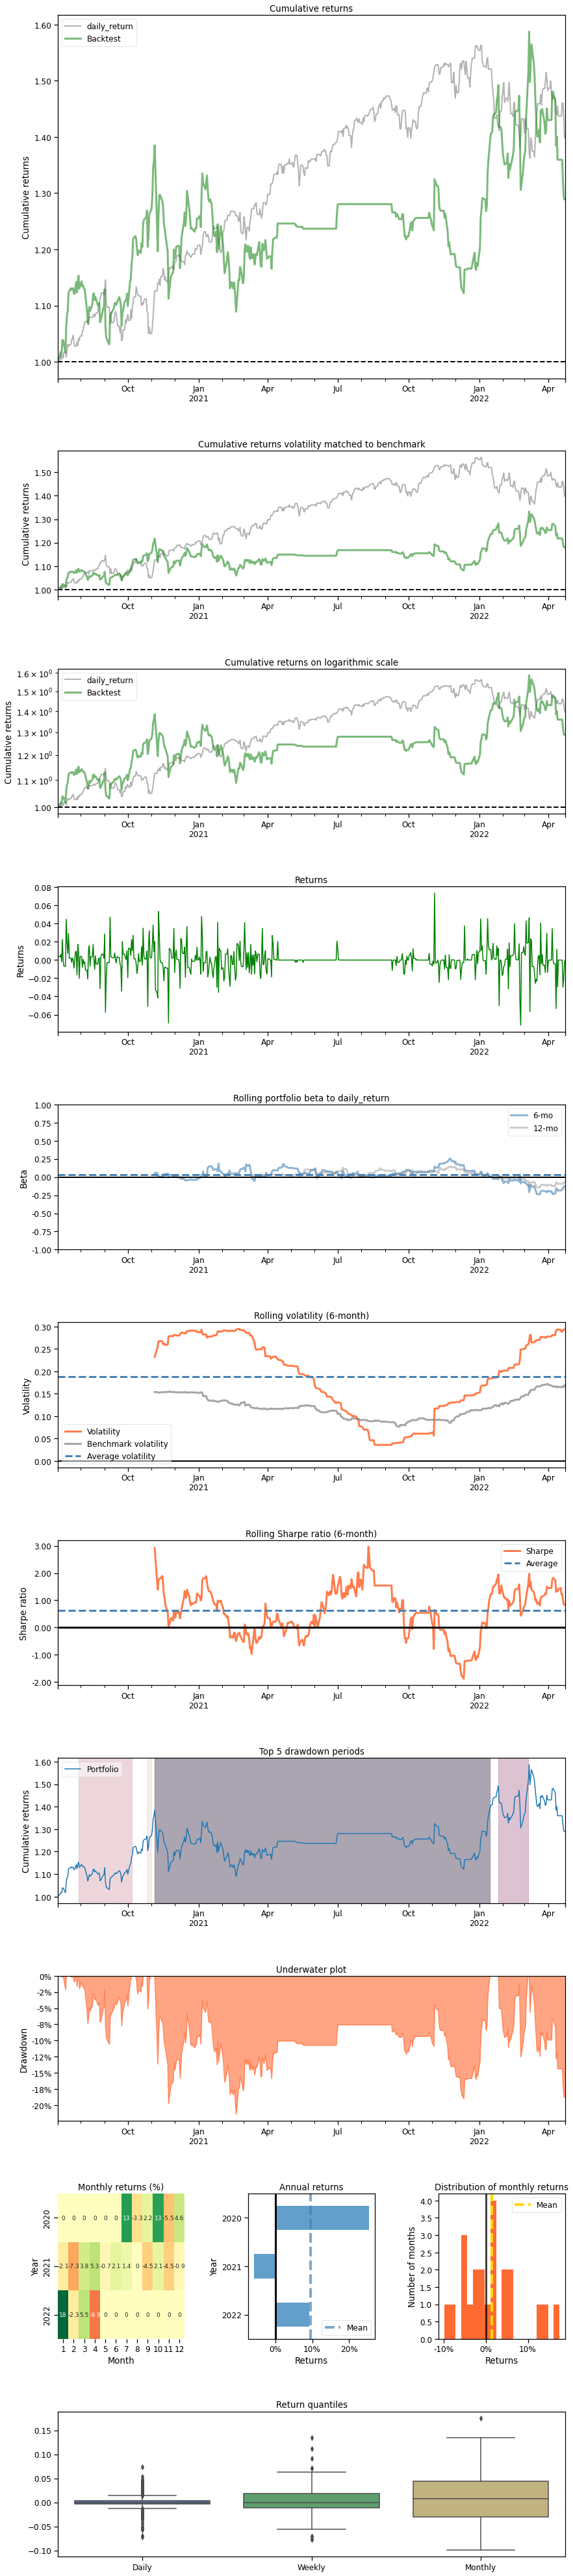

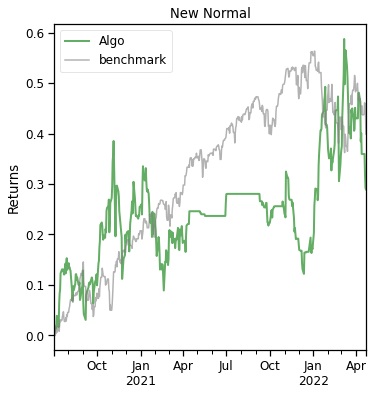

In [37]:
backtest(results['logistic regression'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,12.031%
Cumulative returns,34.715%
Annual volatility,21.551%
Sharpe ratio,0.64
Calmar ratio,0.31
Stability,0.02
Max drawdown,-38.583%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.58,2020-12-17,2021-12-12,NaT,NaN
1,10.78,2020-11-17,2020-11-23,2020-12-13,19
2,10.60,2020-07-29,2020-09-07,2020-10-08,52
3,6.58,2020-11-05,2020-11-07,2020-11-09,3
4,2.79,2020-10-11,2020-10-14,2020-10-21,8


Stress Events,mean,min,max
New Normal,0.05%,-7.36%,5.34%


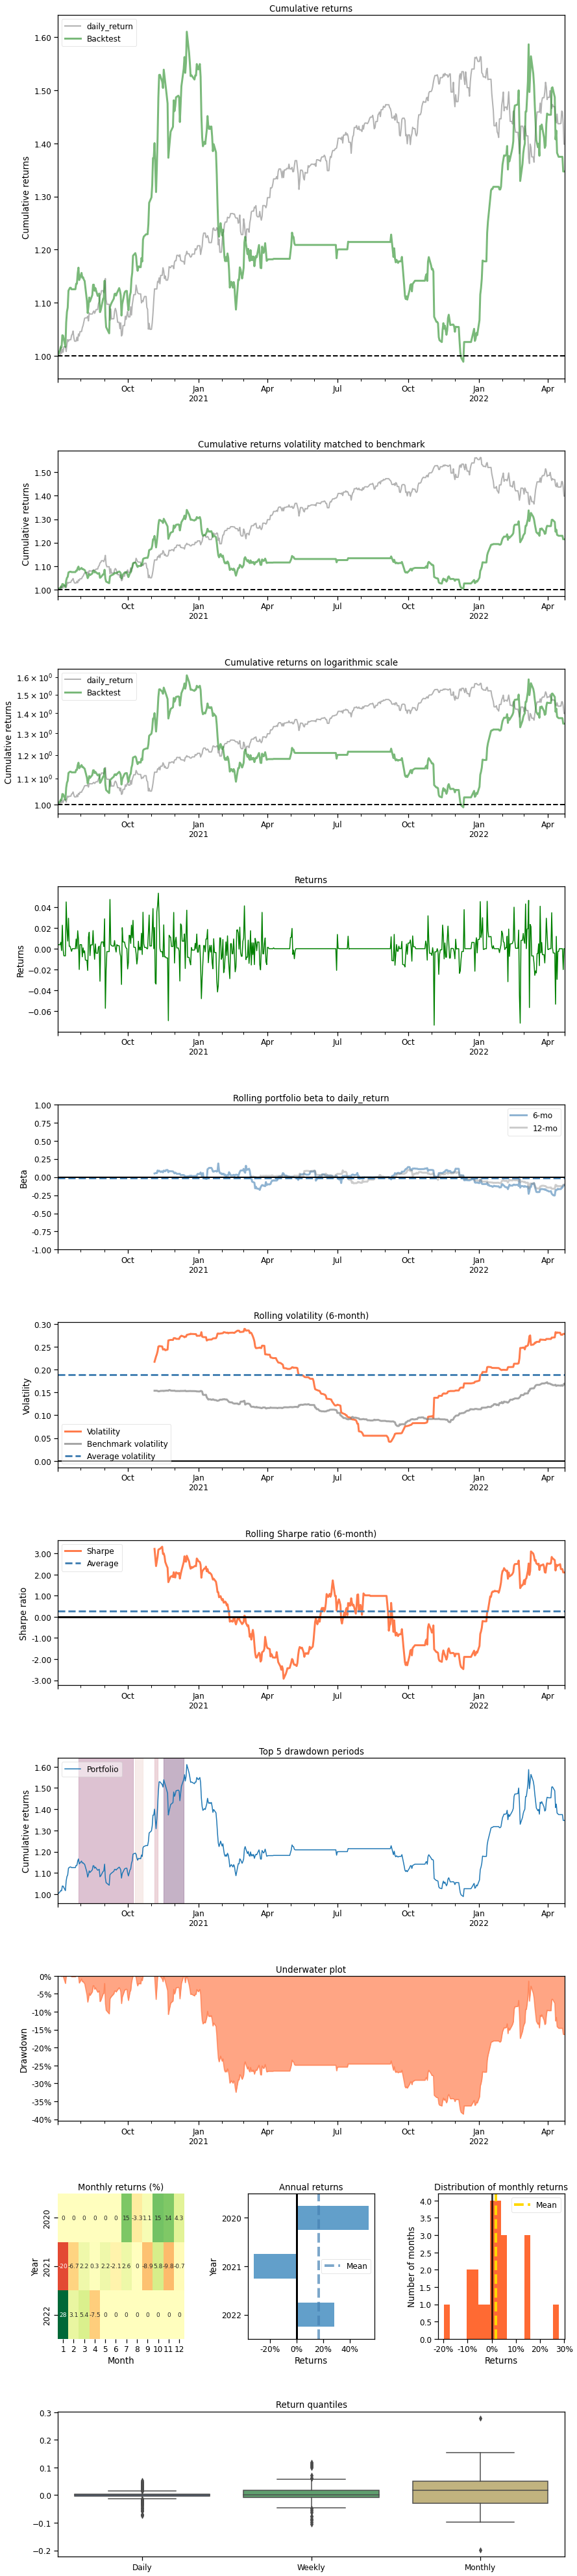

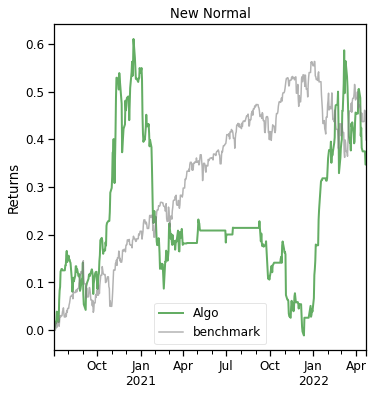

In [38]:
backtest(results['SVC'])

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (456, 8)


Start date,2020-07-02
End date,2022-04-23
Total months,31
,Backtest
Annual return,37.242%
Cumulative returns,129.422%
Annual volatility,20.022%
Sharpe ratio,1.68
Calmar ratio,1.61
Stability,0.49
Max drawdown,-23.087%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,23.09,2020-12-18,2021-07-22,2022-01-13,280
1,10.94,2020-09-01,2020-10-02,2020-10-19,35
2,7.16,2022-02-23,2022-02-24,2022-03-03,7
3,5.37,2022-01-26,2022-01-30,2022-02-16,16
4,5.18,2020-11-12,2020-11-20,2020-11-23,8


Stress Events,mean,min,max
New Normal,0.13%,-7.16%,7.36%


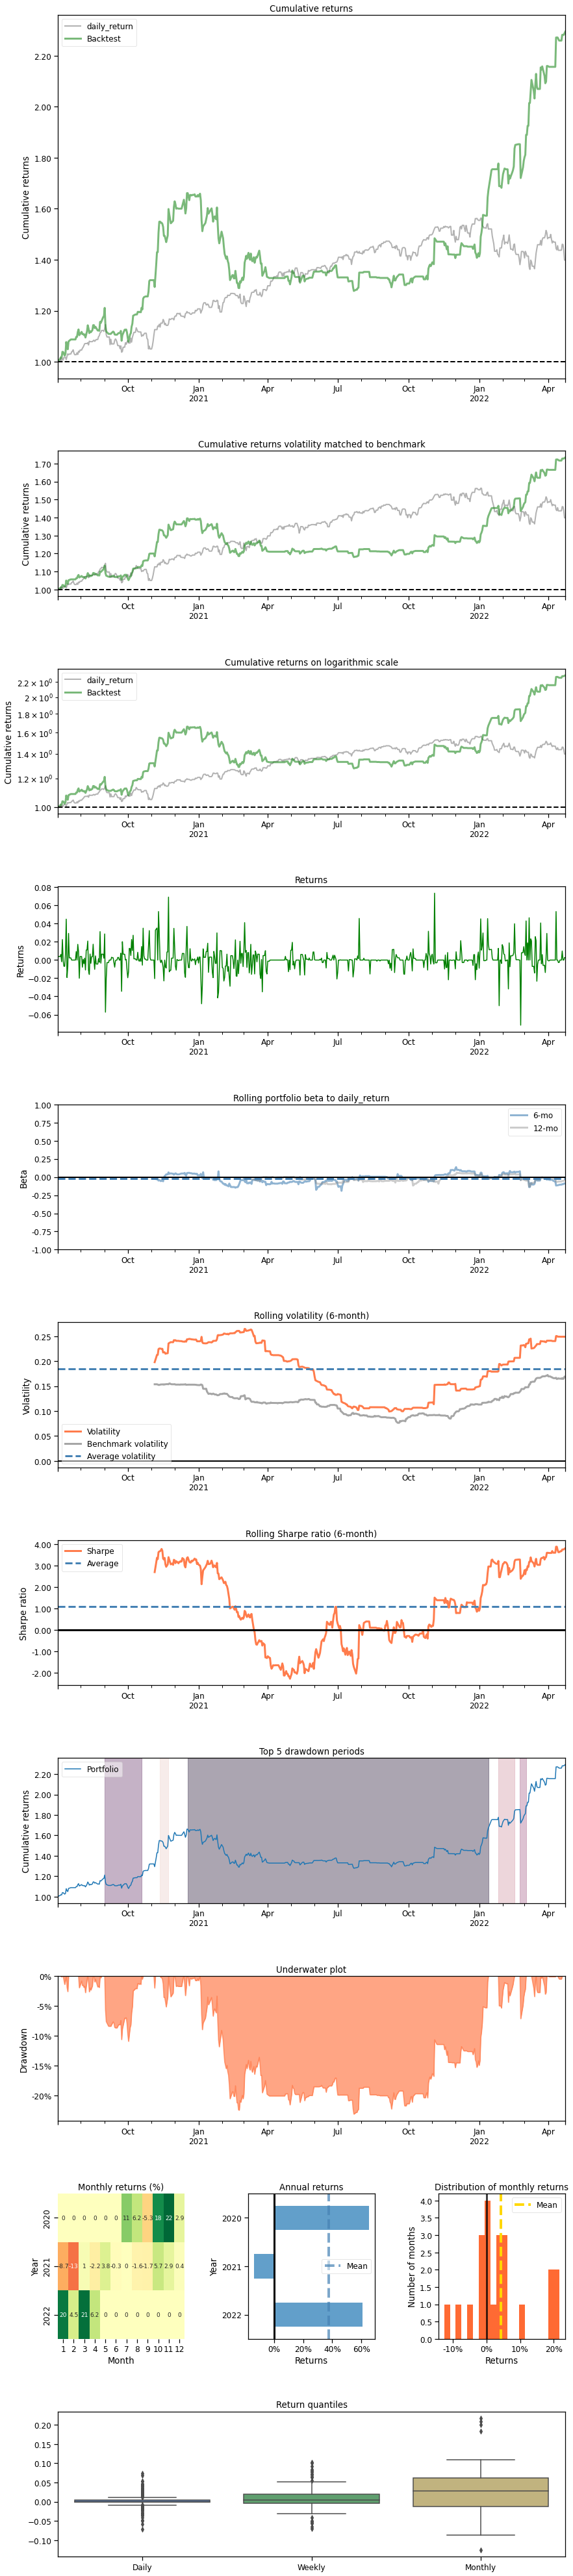

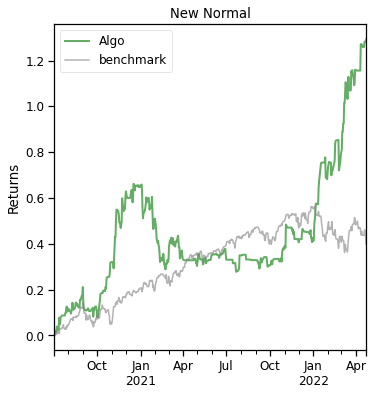

In [39]:
backtest(results['KNN'])